<a href="https://colab.research.google.com/github/Sridevi-SV/customer-churn/blob/main/Customer_Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================
# 0. Mount drive & imports
# ================================
from google.colab import drive
drive.mount('/content/drive')   # mount ONCE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import joblib   # to save models


Mounted at /content/drive


In [ ]:
# ================================
# 1. Load data
# ================================
df = pd.read_excel('/content/drive/MyDrive/Telco_customer_churn.xlsx')
print("Initial shape:", df.shape)
df.head()


Initial shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
# ================================
# 2. Drop irrelevant columns (explicit names, not slices)
# ================================
cols_to_drop = [
    'CustomerID', 'Count', 'Country', 'State', 'City',
    'Zip Code', 'Lat Long', 'Latitude', 'Longitude'
]

cols_present = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=cols_present, inplace=True)
print("Shape after dropping geo/id cols:", df.shape)


Shape after dropping geo/id cols: (7043, 24)


In [ ]:
# ================================
# 3. Inspect and fix data types
# ================================
df.info()   # quick overview

# Converting 'Total Charges' to numeric (coerce errors -> NaN)
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    print("Nulls in Total Charges:", df['Total Charges'].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

In [ ]:
# ================================
# 4. Drop columns with too many missing values (business judgement)
# ================================
# Drop: 'Churn Reason', 'Churn Score', 'CLTV' (73% missing etc.)
for c in ['Churn Reason', 'Churn Score', 'CLTV']:
    if c in df.columns:
        pct_missing = df[c].isnull().mean() * 100
        print(f"{c}: {pct_missing:.1f}% missing")
        df.drop(columns=[c], inplace=True)

# Droping rows with nulls in essential numeric column(s) (Total Charges)
if df['Total Charges'].isnull().sum() > 0:
    df.dropna(subset=['Total Charges'], inplace=True)
    print("Dropped rows with null Total Charges. New shape:", df.shape)


Churn Reason: 73.5% missing
Churn Score: 0.0% missing
CLTV: 0.0% missing
Dropped rows with null Total Charges. New shape: (7032, 21)


In [ ]:
# ================================
# 5. Quick target check & rename if necessary
# ================================
# Using 'Churn Value' as target (0/1). Ensuring it's present and int type.
if 'Churn Value' not in df.columns:
    raise ValueError("Expected 'Churn Value' column as target.")

df['Churn Value'] = df['Churn Value'].astype(int)
print(df['Churn Value'].value_counts(normalize=True))


Churn Value
0    0.734215
1    0.265785
Name: proportion, dtype: float64


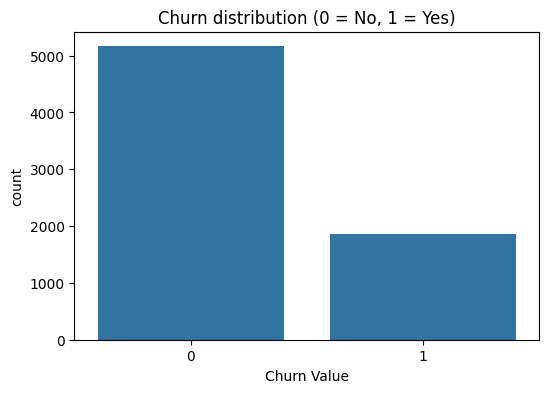


Tenure Months — summary:


,Tenure Months
count,7032.000000
mean,32.421786
std,24.545260
min,1.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,72.000000


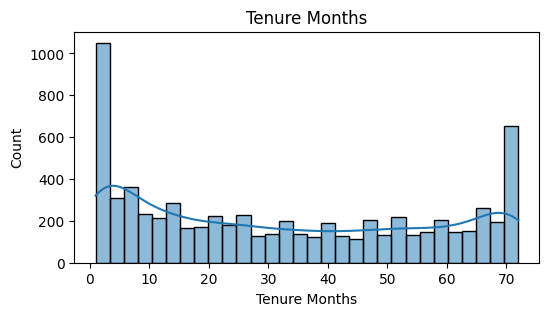


Monthly Charges — summary:


,Monthly Charges
count,7032.000000
mean,64.798208
std,30.085974
min,18.250000
25%,35.587500
50%,70.350000
75%,89.862500
max,118.750000


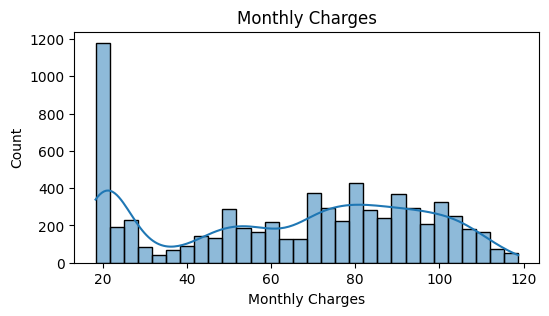


Total Charges — summary:


,Total Charges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


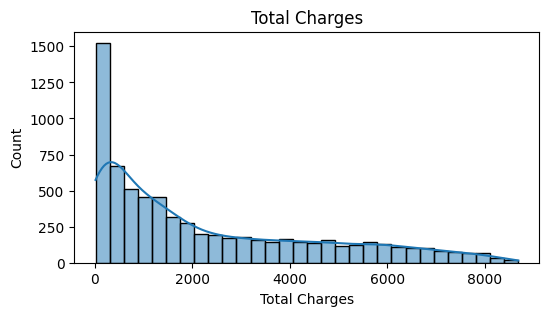

In [ ]:
# ================================
# 6. Basic EDA
# ================================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Churn Value', data=df)
plt.title("Churn distribution (0 = No, 1 = Yes)")
plt.show()

numeric_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
for c in numeric_cols:
    if c in df.columns:
        print(f"\n{c} — summary:")
        display(df[c].describe())
        plt.figure(figsize=(6,3))
        sns.histplot(df[c], kde=True, bins=30)
        plt.title(c)
        plt.show()


In [ ]:
# ================================
# 7. Feature selection
# ================================
# Identify categorical columns (object / categorical)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns count:", len(cat_cols))

# Exclude the target and any columns we already dropped
if 'Churn Label' in df.columns:
    # drop textual 'Churn Label' (we're using Churn Value numeric)
    df.drop(columns=['Churn Label'], inplace=True)

# Do one-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Shape after encoding:", df_encoded.shape)


Categorical columns count: 16
Shape after encoding: (7032, 31)


In [ ]:
# ================================
# 8. Prepare X and y, train-test split (BEFORE scaling and SMOTE)
# ================================
X = df_encoded.drop('Churn Value', axis=1)
y = df_encoded['Churn Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5625, 30) Test shape: (1407, 30)


In [ ]:
# ================================
# 9. Scale numeric features
# ================================
num_cols_present = [c for c in numeric_cols if c in X_train.columns]
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols_present])
X_test_num = scaler.transform(X_test[num_cols_present])

# Replace numeric columns with scaled arrays
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols_present] = X_train_num
X_test_scaled[num_cols_present] = X_test_num

# Save scaler
joblib.dump(scaler, '/content/drive/MyDrive/scaler_churn.joblib')
print("Scaler saved.")


Scaler saved.


In [ ]:
# ================================
# 10. Handle imbalance with SMOTE
# ================================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", X_train_res.shape, y_train_res.value_counts(normalize=True).to_dict())


After SMOTE: (8260, 30) {0: 0.5, 1: 0.5}


In [ ]:
# ================================
# 11.kept top 20 by ANOVA F-score
# ================================
n_features = X_train_res.shape[1]
k = min(20, n_features)
selector = SelectKBest(score_func=f_classif, k=k)
X_train_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_scaled)

selected_features = X_train_res.columns[selector.get_support()]
print("Selected features ({}):\n".format(len(selected_features)), selected_features.tolist())


Selected features (20):
 ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Senior Citizen_Yes', 'Dependents_Yes', 'Internet Service_Fiber optic', 'Internet Service_No', 'Online Security_No internet service', 'Online Security_Yes', 'Online Backup_No internet service', 'Device Protection_No internet service', 'Tech Support_No internet service', 'Tech Support_Yes', 'Streaming TV_No internet service', 'Streaming Movies_No internet service', 'Contract_One year', 'Contract_Two year', 'Paperless Billing_Yes', 'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check']


In [ ]:
# ================================
# 12. Train simple models (Logistic, RandomForest, XGBoost)
# Evaluating with accuracy + ROC-AUC + classification_report.
# ================================
# Preparing final train/test arrays
X_tr = X_train_sel
X_te = X_test_sel

# Logistic Regression
log = LogisticRegression(max_iter=1000, random_state=42)
log.fit(X_tr, y_train_res)
y_pred_log = log.predict(X_te)
y_proba_log = log.predict_proba(X_te)[:,1]

print("LOGISTIC REGRESSION")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


LOGISTIC REGRESSION
Accuracy: 0.7398720682302772
ROC-AUC: 0.8415005357947104
Confusion Matrix:
 [[749 284]
 [ 82 292]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_tr, y_train_res)
y_pred_rf = rf.predict(X_te)
y_proba_rf = rf.predict_proba(X_te)[:,1]

print("RANDOM FOREST")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

joblib.dump(rf, '/content/drive/MyDrive/rf_churn_model.joblib')
print("Random Forest model saved.")


RANDOM FOREST
Accuracy: 0.7526652452025586
ROC-AUC: 0.8435932412215086
Confusion Matrix:
 [[768 265]
 [ 83 291]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.82      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407

Random Forest model saved.


In [ ]:
# XGBoost
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_clf.fit(X_tr, y_train_res)
y_pred_xgb = xgb_clf.predict(X_te)
y_proba_xgb = xgb_clf.predict_proba(X_te)[:,1]

print("XGBOOST")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

joblib.dump(xgb_clf, '/content/drive/MyDrive/xgb_churn_model.joblib')
print("XGBoost model saved.")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:05:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBOOST
Accuracy: 0.7469793887704336
ROC-AUC: 0.8192132877088176
Confusion Matrix:
 [[789 244]
 [112 262]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

XGBoost model saved.


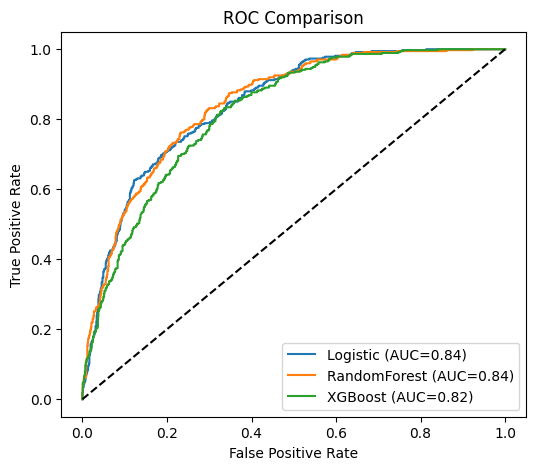

In [ ]:
# ================================
# 13. Ploting ROC curves (comparison)
# ================================
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
plt.plot(fpr, tpr, label=f'Logistic (AUC={roc_auc_score(y_test, y_proba_log):.2f})')
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f'RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.2f})')
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc_score(y_test, y_proba_xgb):.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend()
plt.show()
